# Búsqueda del factor escalado k calibrado para un sacádico de 21 grados.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy
import nest
nest.Install('scmodule')
nest.SetKernelStatus({"resolution": 0.01})

In [2]:
num_neurons = 200
sigma = 8.0 #ms amplitud de la kernel gaussiana
min_tau = 10.0 #constante de tiempo de adaptación mínima
max_tau = 80.0 #constante de tiempo de adaptación máxima
wexc_factor = 0.160 #nS Factor de excitación
winh_factor = 0.05 #nS Factor de inhibición
syn_exc = 0.4 #mm rango de sinápsis excitatorias
syn_inh = 1.2 #mm rango de sinápsis inhibitorias
max_pos = 5.0 #mm posición anatómica máxima
min_pos = 0.0 #mm posición anatómica mínima
#Logarithmic mapping function
Bu = 1.4 #mm
A = 3 #deg
r = 21 #para calibrar el factor de k
simulation_len = 300.0
k = 1.089216e-3

In [3]:
position = numpy.linspace(min_pos, max_pos, num_neurons)
ut=Bu*numpy.log((r+A)/A) #posición del sacádico en función de la amplitud
distance = numpy.zeros(len(position))
#matriz de distancias entre la posición central de sacádico y la posición de la neurona
for idx_p,pos in enumerate(position):
    distance[idx_p] = numpy.absolute(pos-ut)  

Obtengo la posición del sacádico mediante la función logarítmica en función de la amplitud del mismo. Creo una matriz de distancias con la diferencia entre la posición de la neurona y la posición de la neurona central donde se produce el sacádico, y utilizo la distancia para la definición de los parámetros de la capa del generador.

In [4]:
GEN_list = []
for dist in distance:
    GEN_list.append({"i0":3.0, "beta":0.03, "gamma":1.8, "pop":0.5, "sc_onset":0.0, "distance":dist})
GEN_pop = nest.Create("sc_generator", num_neurons, params=GEN_list)

In [5]:
FEF_dict = {"C_m":50.0,"t_ref":0.0,"V_reset":-55.0,"E_L":-70.0, "g_L":2.0, "I_e":0.0, "a":0.0, "b":60.0, 
            "Delta_T":2.0, "tau_w":30.0, "V_th":-50.0, "V_peak":-30.0}
FEF_pop = nest.Create("aeif_cond_exp", num_neurons, params=FEF_dict)

Añado los parámetros de la constante de tiempo de adaptación, que sigue una distribución lineal a lo largo del mapa motor visual, y las conexiones laterales dentro de la capa SC.

In [6]:
tau_net = numpy.linspace(max_tau, min_tau, num_neurons)
SC_list = []
for tau_w in tau_net:
    SC_list.append({"C_m":280.0,"t_ref":0.0, "V_reset":-45.0, "E_L":-70.0, "g_L":10.0,"I_e":0.0, "a":4.0,
                    "b":80.0, "Delta_T":2.0,"V_th":-50.0, "V_peak":-30.0,"E_ex":0.0, "tau_syn_ex":5.0,
                    "E_in":-80.0, "tau_syn_in":10.0, "tau_w":tau_w})  
SC_pop = nest.Create("aeif_cond_exp",num_neurons, params=SC_list)

In [7]:
#Lateral intracollicular connections
position = numpy.linspace(min_pos, max_pos, num_neurons)

wexc = numpy.zeros((num_neurons*num_neurons))
sc_filas = numpy.repeat(range(num_neurons), num_neurons)
sc_colum = numpy.tile(range(num_neurons), num_neurons)
wexc = wexc_factor*numpy.exp(-(numpy.square(position[sc_filas]-position[sc_colum]))
                             /(2*numpy.square(syn_exc)))        
wexc = wexc.reshape((num_neurons,num_neurons))
numpy.fill_diagonal(wexc,0)

wind = numpy.zeros((num_neurons*num_neurons))
ind_filas = numpy.repeat(range(num_neurons), num_neurons)
ind_colum = numpy.tile(range(num_neurons), num_neurons)
winh = winh_factor*numpy.exp(-(numpy.square(position[ind_filas]-position[ind_colum]))
                             /(2*numpy.square(syn_inh)))        
winh = winh.reshape((num_neurons,num_neurons))
numpy.fill_diagonal(winh,0)

conn_dict = {'rule':'all_to_all', 'autapses': True}

syn_dict_exc = {'weight': wexc, 'delay':1.0}
nest.Connect(SC_pop, SC_pop, conn_spec = conn_dict, syn_spec = syn_dict_exc)

syn_dict_inh = {'weight': -winh, 'delay':1.0}
nest.Connect(SC_pop, SC_pop,  conn_spec = conn_dict, syn_spec = syn_dict_inh)

Utilizo el polinomio de ajuste para encontrar los correspondiente pesos sinápticos a cada constante de tiempo de adaptación. e introduzco dichos pesos sinápticos a la hora de definir la sinapsis entre la capa FEF y la capa SC.

In [8]:
def funcion_polinomio(tau_net):
    return ((-0.001803*tau_net*tau_net) + (0.2925*tau_net) + 3.432)
wei_net = funcion_polinomio(tau_net)

In [9]:
nest.Connect(GEN_pop, FEF_pop, "one_to_one", syn_spec={'weight':1.0, 'delay':1.0})
syn_dict = {'weight': wei_net, 'delay':1.0}
nest.Connect(FEF_pop, SC_pop, "one_to_one",  syn_spec=syn_dict)

Site-specific, fixed, minivector given by the efferent motor map.

In [10]:
mn = []
for pos in position:
    mn.append(k*A*numpy.exp(pos/Bu))

In [11]:
spikedetector = nest.Create("spike_detector", params={"withgid":True, "withtime":True})
nest.Connect(SC_pop, spikedetector, syn_spec={'delay':1.0})

In [12]:
nest.Simulate(simulation_len)

In [13]:
dSD = nest.GetStatus(spikedetector)[0]
evs = dSD["events"]["senders"]
tspk = dSD["events"]["times"]

Obtengo la trayectoria del movimiento sacádico.

In [14]:
first_SC = numpy.min(SC_pop)
t = numpy.arange(0.0, 120.0, 0.1)
suma = numpy.zeros(len(t))
for sptime,spneu in zip(tspk,evs):
    sel_time = (t>=sptime)
    suma[sel_time] = suma[sel_time]+mn[spneu-first_SC]
print suma

[  0.           0.           0.         ...,  20.99999974  20.99999974
  20.99999974]


<IPython.core.display.Javascript object>


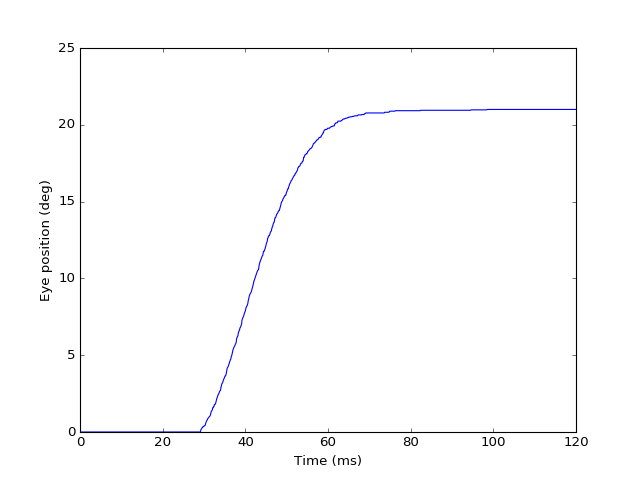

In [16]:
plt.figure()
plt.plot(t, suma)
plt.xlabel('Time (ms)')
plt.ylabel('Eye position (deg)')

Fig. 18.Trayectoria del movimiento ocular para un sacádico de 21°. Describe la posición
del ojo en función del tiempo.